### Student Information
Name: 李季軒 Lee, CHI-HSUAN

Student ID: B10902111 (NTU)

GitHub ID: LEE-CHI-HSUAN

Kaggle name: leechihsuan

Kaggle private scoreboard snapshot:

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

## Abstract

My workflow include several steps, and each steps can have a few variation. The notebook contains all attempt I tried, but only a part of them are used. I will show the final method at the end of this notebook.

### Workflow

1. Data preparation
2. Sampling
3. Text embedding
4. Classifier training

In [2]:
import json
import nltk
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

## Data preparation

This steps read CSV files and organize them to a trainind dataframe and a testing dataframe.

In [3]:
# map id -> train/test
id2split = pd.read_csv("data_identification.csv", index_col="tweet_id").to_dict()["identification"]
# map id -> emotion
id2label = pd.read_csv("emotion.csv", index_col="tweet_id").to_dict()["emotion"]

In [4]:
### Load data
with open("tweets_DM.json", "r") as fin:
    examples = (json.loads(line) for line in fin)

    dataset = (
        {
            "id":       example["_source"]["tweet"]["tweet_id"],
            "hashtags": example["_source"]["tweet"]["hashtags"],
            "text":     example["_source"]["tweet"]["text"],
            "label": id2label.get(example["_source"]["tweet"]["tweet_id"], np.nan),
            "split": id2split[example["_source"]["tweet"]["tweet_id"]],
        }
        for example in examples
    )

    df = pd.DataFrame(dataset)

df.head(3)

,id,hashtags,text,label,split
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",anticipation,train
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",sadness,train
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",NaN,test


Split train/test datasets.

In [5]:
df_train = df[df['split'] == 'train'].drop(columns="split")
df_test = df[df['split'] == 'test'].drop(columns="split")

Total examples:  1455563


<Axes: xlabel='label'>

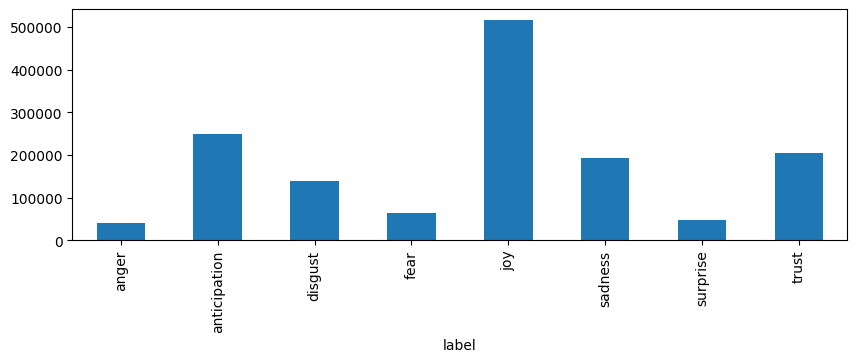

In [6]:
print("Total examples: ", len(df_train))
df_train.groupby("label").size().plot(kind="bar", figsize=(10, 3))

Training set is too big and the labels are inbalance, so we are going to sample a subset. This can reduce the trainig time and make classifiers less biased.

Sampled size:  12622


<Axes: xlabel='label'>

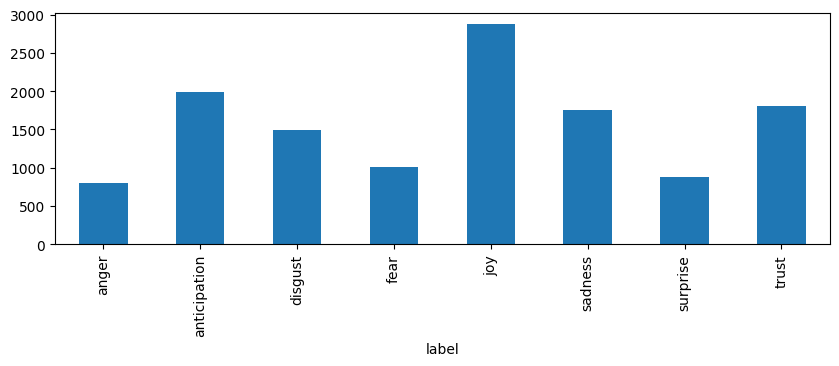

In [ ]:
# Determine the number of samples for each label
# Note that log is used to even the number difference between labels
# square root can replace log if you want to preserve more difference.
label_counts = df_train.groupby("label").size()
sample_counts = np.log2(label_counts) * 100
#sample_counts = np.sqrt(label_counts) * 4

# Sample a subset from the original training set
sampled_df = pd.DataFrame()
for label, count in sample_counts.items():
    sample = df_train[df_train["label"] == label].sample(n=int(count))
    sampled_df = pd.concat([sampled_df, sample])

print("Sampled size: ", len(sampled_df))
sampled_df.groupby("label").size().plot(kind="bar", figsize=(10, 3))

In [7]:
df_train = sampled_df

## Text embedding

I've tried three ways to embed models: LM embedding, Bag-of-word+term frequency, and Bag-of-word+TF-IDF.

#### LM embedding

It is the most straight forward method but time consuming. The generation of all text embeddings takes hours of time. The generated embeddings are dense vectors and are suitable for k-nearest-neighbor classifier, which results in a F1-score of about 0.40.

In [10]:
from ollama import Client

# Define a function to generate embeddings
client = Client(host='http://140.112.30.56:41124')
def generate_embeddings(row: list[str]):
    embeddings = client.embed(
        model="llama3.1:latest",
        input=row,
    )
    return embeddings["embeddings"]

In [11]:
embeddings = []
batch_size = 64
for i in tqdm(range(0, len(df_train.text), batch_size), desc="Generating Embeddings"):
    embeddings.extend(generate_embeddings(df_train.text[i : i + batch_size].tolist()))

Generating Embeddings: 100%|██████████| 213/213 [06:35<00:00,  1.86s/it]


In [12]:
X = embeddings

Visualize the distribution of embeddings.

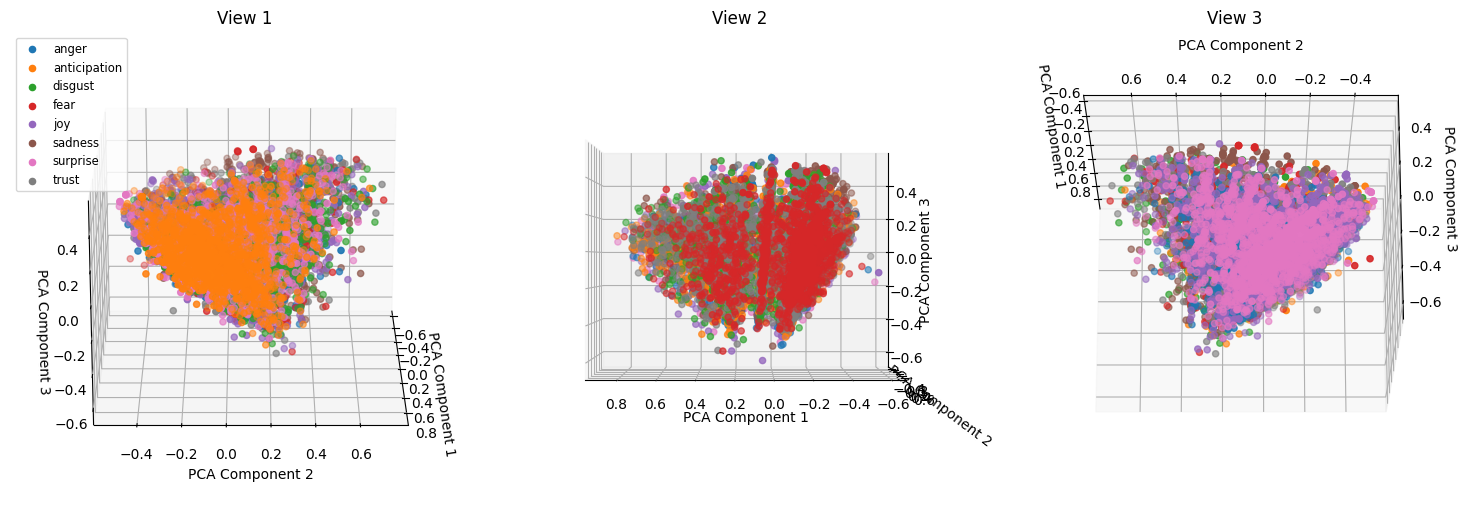

In [188]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA with 3 components for 3D visualization
pca = PCA(n_components=3)
x3d = pca.fit_transform(X)

# --- Create a figure with subplots for different angles ---
fig = plt.figure(figsize=(15, 5))

# Define viewing angles
views = [(20, 0), (0, 90), (-20, 180)]  # (elev, azim)
df_train_no_index = df_train.reset_index()
# --- Iterate through the views to create subplots ---
for i, (elev, azim) in enumerate(views):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    #ax.scatter(x3d[:, 0], x3d[:, 1], x3d[:, 2], c='grey', label='All Data', alpha=0.5)

    # Efficiently get indices for each label
    for label in df_train.label.unique():
        indices = df_train_no_index.index[df_train.label == label]  # No need to reset index
        ax.scatter(x3d[indices, 0], x3d[indices, 1], x3d[indices, 2], label=label)

    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title(f"View {i+1}")

    if elev is not None and azim is not None:
        ax.view_init(elev=elev, azim=azim)

    if i == 0:  # Only show legend on the first plot
        ax.legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()



#### BOW+term frequency

This is a baseline for comparing TF-IDF. I'm not mean to spend much time on this so keep it simple. I just choose terms that has the highest frequencies to be the features.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize)
BOW_500.fit(df['text'])

c:\Users\james\anaconda3\envs\DataMining\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=500,
                tokenizer=<function word_tokenize at 0x0000019632028B80>)

As we can see, it consists of many meaning less term. These term seem not to be representative.

In [27]:
BOW_500.get_feature_names_out()

array(['!', '#', '$', '%', '&', "'", "''", "'d", "'ll", "'m", "'re", "'s",
       "'ve", '(', ')', '*', ',', '-', '.', '..', '...', '....', '.....',
       '1', '1.0', '10', '2', '20', '2017', '3', '4', '5', ':', ';', '<',
       '=', '>', '?', '@', '``', 'a', 'able', 'about', 'actually',
       'after', 'again', 'against', 'ago', 'all', 'almost', 'alone',
       'already', 'also', 'always', 'am', 'amazing', 'america', 'an',
       'and', 'another', 'any', 'anyone', 'anything', 'are', 'around',
       'as', 'ask', 'ass', 'at', 'august', 'away', 'awesome', 'baby',
       'back', 'bad', 'be', 'beautiful', 'because', 'become', 'bed',
       'been', 'before', 'being', 'believe', 'best', 'better', 'big',
       'birthday', 'black', 'bless', 'blessed', 'book', 'both', 'bring',
       'but', 'buy', 'by', 'ca', 'call', 'called', 'came', 'can', 'car',
       'care', 'cause', 'change', 'christmas', 'class', 'closed', 'come',
       'comes', 'coming', 'could', 'country', 'crazy', 'd', 'damn', 'da

Prepare datasets.

In [ ]:
X = BOW_500.transform(df_train["text"])

#### TF-IDF

I designed a more sophisticated method to select features. TF-IDF can scale down the importance of common words. A lemmatizer is used to reduce noise and the number of terms, allowing TF-IDF to capture keys from clean data.

This method is suitable for **random forest** but poor for **k nearest neighbor** because a text embedding is a sparse vector. With the curse of dimensions, difference of each element of a sparse vector are minimized.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer

# turn words to their original form
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

# set max_df to remove too common words
# set min_df to remove words appears only twice or fewer, because those are less referenceable or might just be noise.
tf_vectorizer = TfidfVectorizer(max_features=1000, tokenizer=LemmaTokenizer(), max_df=0.5, min_df=2)
tfidf_matrix = tf_vectorizer.fit_transform(df_train['text'])

c:\Users\james\anaconda3\envs\DataMining\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


And them I calculate the mean TF-IDF value of each term and keep the top 1000 as the features.

In [150]:
# Calculate the mean TF-IDF score for each feature across the corpus
mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).squeeze()
mean_tfidf

array([0.05994618, 0.00241923, 0.00165176, 0.01270461, 0.00320732,
       0.00987525, 0.00233399, 0.00282736, 0.0108631 , 0.00498126,
       0.01885765, 0.00399242, 0.00459763, 0.00546115, 0.00298159,
       0.000514  , 0.03894782, 0.00613528, 0.00078363, 0.06108023,
       0.00833843, 0.01643877, 0.00572437, 0.00206425, 0.00079156,
       0.00067286, 0.00276735, 0.00033614, 0.00069901, 0.00052379,
       0.00127897, 0.00099416, 0.00073976, 0.00069035, 0.00091634,
       0.00055871, 0.00077962, 0.00490194, 0.00108393, 0.00441204,
       0.00059693, 0.00264033, 0.00095792, 0.00269614, 0.00054172,
       0.00166475, 0.00059576, 0.00114036, 0.00098431, 0.00094174,
       0.01017817, 0.00379229, 0.00460258, 0.03241403, 0.08301475,
       0.00088963, 0.00081657, 0.01006119, 0.03976961, 0.00083306,
       0.0084145 , 0.00136895, 0.00108879, 0.00104961, 0.00113408,
       0.00153247, 0.00080167, 0.00061075, 0.00360752, 0.00383563,
       0.0014399 , 0.00117796, 0.00071133, 0.00071995, 0.00096

Before selecting features.

In [ ]:
tf_vectorizer.get_feature_names_out()

array(['!', '$', '%', '&', "'", "''", "'d", "'ll", "'m", "'re", "'s",
       "'ve", '(', ')', '*', '+', ',', '-', '--', '.', '..', '...',
       '....', '.....', '......', '0,16', '1', '1,42', '1.0', '1/2', '10',
       '100', '11', '12', '15', '18', '1st', '2', '20', '2017', '23', '3',
       '30', '4', '40', '5', '50', '6', '7', '8', ':', ';', '=', '?', '@',
       '[', ']', '``', 'a', 'able', 'about', 'absolutely', 'account',
       'act', 'action', 'actually', 'add', 'afraid', 'after', 'again',
       'against', 'ago', 'agree', 'ahead', 'ai', 'air', 'album', 'alive',
       'all', 'almost', 'alone', 'already', 'also', 'always', 'am',
       'amazing', 'america', 'american', 'an', 'and', 'anger', 'angry',
       'annoyed', 'annoying', 'another', 'answer', 'any', 'anymore',
       'anyone', 'anything', 'app', 'apparently', 'apple', 'appreciate',
       'are', 'around', 'as', 'ask', 'asked', 'asleep', 'at', 'august',
       'away', 'awesome', 'awkward', 'b', 'baby', 'back', 'bad', 'ba

In [152]:
# Get important features based on their mean TF-IDF scores
top_n = 1000
top_indices = np.argsort(mean_tfidf)[-top_n:]

# Get the top features and their scores
top_features = feature_names[top_indices]

After selecting features.

In [153]:
top_features

array(['1,42', '+', '‘', '1/2', 'deep', 'yr', 'laugh', 'supposed', '40',
       'sale', 'twice', 'f', 'scared', '18', 'force', 'mark', 'sent',
       'write', 'worry', 'store', 'wear', 'body', 'sleeping', 'hoping',
       'space', 'staff', 'bag', 'courage', 'brown', 'lt', 'evening',
       'quick', 'door', 'sign', 'worse', 'asleep', '50', '23', 'wife',
       'student', 'excuse', 'passion', 'page', 'skin', 'app', 'clean',
       'course', 'broke', 'rich', 'hbo', 'instagram', 'apple', 'afraid',
       'product', 'ordered', 'law', 'blood', 'fix', 'facebook', 'later',
       'born', 'rock', 'update', 'alive', 'wearing', 'husband', 'tear',
       'busy', 'group', 'entire', 'frustrated', 'shut', 'due', 'cat',
       'leadership', 'annoying', 'december', 'save', 'deal', 'box',
       'price', 'sun', 'police', 'politics', 'didn', 'trip',
       'relationship', 'dumb', 'step', 'appreciate', 'air', '~', 'daily',
       'foot', 'tax', 'beer', 'offer', 'character', '🇪🇺eur',
       'mondaymotivati

In [ ]:
X = tf_vectorizer.transform(df_train["text"])
X = X[:,top_indices]

### Finalize datasets for training

In [161]:
from sklearn.model_selection import train_test_split

y = df_train.label
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


def evaluate(y_train_pred: list, y_val_pred: list) -> None:
    acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test = accuracy_score(y_true=y_val, y_pred=y_val_pred)

    print(f"training accuracy: {acc_train:.2f}")
    print(f"testing accuracy:  {acc_test:.2f}")
    print(f"F1:  {f1_score(y_true=y_val,   y_pred=y_val_pred, average='weighted'):.2f}")

    ## check by confusion matrix
    cm = confusion_matrix(y_true=y_val, y_pred=y_val_pred)
    print(cm)

## Model training

I've tried 4 models

1. Naive Bayes: a baseline
2. k Nearest Neighbor: fit LM embedding
3. Random Forest: a simple but robust method
4. Gradient Boost: a nother robust method

### Naive Bayes

Although it is not the strongest model. The training of it is fast so it works as a indicator to see whether my preprocessing method is good.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# train
NB_model = MultinomialNB().fit(X_train, y_train)

# predict
y_train_pred = NB_model.predict(X_train)
y_val_pred = NB_model.predict(X_val)

In [432]:
evaluate(y_train_pred, y_val_pred)

training accuracy: 0.38
testing accuracy:  0.37
F1:  0.33
[[  354   130   483    25  2368   520    10    28]
 [    8  3656   200    37  5419   463    17   238]
 [   16   247  1581    51  4266  1166    16    61]
 [    9   271   210  1284  2942   337    17    31]
 [    9   835   204    73 12292   520    15   384]
 [   14   343   592    55  4670  2981    27    70]
 [    8   185   284    36  3069   579   304    38]
 [    9   760   151    28  6746   334     9  1050]]


### k Nearest Neighbors

This method heavily relys on the density of the data, so it works well with LM embeddings because those embeddings are dense vectors possessing rich sementic meanings. However, it performs really bad with sparse vectors, so BOW doesn't work well with it.

In [162]:
from sklearn.neighbors import KNeighborsClassifier

# train
kNN = KNeighborsClassifier(n_neighbors=20, metric="euclidean", weights="distance").fit(X_train, y_train)

# predict
y_train_pred = kNN.predict(X_train)
y_val_pred = kNN.predict(X_val)

In [163]:
evaluate(y_train_pred, y_val_pred)

training accuracy: 1.00
testing accuracy:  0.23
F1:  0.22
[[ 38  46   9  49  77  30  31  41]
 [  4 102   6  34 105  17  31  49]
 [ 12  38  31  53  81  38  29  56]
 [  7  36  13  84  81  28  20  28]
 [ 10  48   6  36 128  34  40  61]
 [ 10  49  23  59  89  74  35  58]
 [  4  36  13  43  73  19  60  40]
 [  6  51   3  48 124  14  24  98]]


log:
mxbai, n_neighbors=40, F1=0.41
bge-m3, n_neighbors=20, F1=0.41
nomic, n_neighbors=20, F1=0.39
llama3.1, n_neighbors=20, F1=0.37

### Random Forest

Random Forest performs similarly across all text embedding methods. Although gradient boosting outperforms it, its training time is relatively fast, making it a convenient baseline that can generally be applied to many datasets.

In [174]:
from sklearn.ensemble import RandomForestClassifier

# train
RF_model = RandomForestClassifier(max_depth=30, n_estimators=100, n_jobs=4, verbose=1).fit(X_train, y_train)

# predict
y_train_pred = RF_model.predict(X_train)
y_val_pred = RF_model.predict(X_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [175]:
evaluate(y_train_pred, y_val_pred)

training accuracy: 0.88
testing accuracy:  0.33
F1:  0.33
[[ 71  24  70  29  55  34   8  30]
 [ 11 138  38  29  73  20   6  33]
 [ 19  26 137  20  56  56   2  22]
 [ 14  23  44 125  52  15   4  20]
 [ 16  34  44  23 170  24   3  49]
 [ 17  39  87  32  65 113   8  36]
 [  8  26  56  27  55  33  54  29]
 [ 15  41  50  32 104  24   4  98]]


log:
mxbai, n_estimators=80, F1=0.35
bge-m3, n_estimators=80, F1=0.34
nomic, n_estimators=80, F1=0.34
llama3.1, n_estimators=80, F1=0.36

###  Gradient Boost

This is an alternative to random forest. Both are aggregation methods and have similar performance, but it cannot be trained in parallel, making it slower to train. It is comparable to random forest.

In [166]:
from sklearn.ensemble import HistGradientBoostingClassifier

# train
GB_model = HistGradientBoostingClassifier(max_iter=50, verbose=1).fit(X_train.toarray(), y_train)

# predict
y_train_pred = GB_model.predict(X_train.toarray())
y_val_pred = GB_model.predict(X_val.toarray())

Binning 0.078 GB of training data: 0.491 s
Binning 0.009 GB of validation data: 0.011 s
Fitting gradient boosted rounds:
[1/50] 8 trees, 248 leaves (31 on avg), max depth = 20, train loss: 1.97150, val loss: 1.99231, in 0.721s
[2/50] 8 trees, 248 leaves (31 on avg), max depth = 24, train loss: 1.90509, val loss: 1.94508, in 0.714s
[3/50] 8 trees, 248 leaves (31 on avg), max depth = 25, train loss: 1.85238, val loss: 1.91208, in 0.700s
[4/50] 8 trees, 248 leaves (31 on avg), max depth = 25, train loss: 1.80857, val loss: 1.88526, in 0.757s
[5/50] 8 trees, 248 leaves (31 on avg), max depth = 27, train loss: 1.77036, val loss: 1.86501, in 0.731s
[6/50] 8 trees, 248 leaves (31 on avg), max depth = 27, train loss: 1.73624, val loss: 1.84813, in 0.729s
[7/50] 8 trees, 248 leaves (31 on avg), max depth = 24, train loss: 1.70500, val loss: 1.83505, in 0.848s
[8/50] 8 trees, 248 leaves (31 on avg), max depth = 24, train loss: 1.67716, val loss: 1.82202, in 0.800s
[9/50] 8 trees, 248 leaves (31 

In [167]:
evaluate(y_train_pred, y_val_pred)

training accuracy: 0.71
testing accuracy:  0.33
F1:  0.33
[[ 90  26  54  20  48  39  26  18]
 [ 18 144  25  21  63  18  23  36]
 [ 38  21 111  23  34  54  31  26]
 [ 22  25  32 130  33  13  15  27]
 [ 19  45  31  32 135  24  24  53]
 [ 42  37  62  36  44 112  24  40]
 [ 17  27  48  24  50  25  76  21]
 [ 17  42  33  27  89  25  23 112]]


log:
mxbai, max_iter=100, F1=0.41
bge-m3, max_iter=50, F1=0.39
nomic, max_iter=50, F1=0.39
llama3.1: max_iter=50, F1=0.41
llama3.1: max_iter=100, F1=0.42

## Conclusion

After all this experiment, my final setup is sample a subset from the training set, adjusting the ratio of labels by square root of their original size. Then, I create features with LM (mxbai-embed-large) embedding. Finally, I trained a k nearest neighbor classifier and use the 40 neighbor to predict the labels.

## Prediction

Following is a code that I used to generate files that need to be submitted to Kaggle.

prepare dataset

In [84]:
#X_test = tf_vectorizer.transform(df_test["text"])
# X_test = X_test[:,top_indices]

X_test = []
batch_size = 64
for i in tqdm(range(0, len(df_test.text), batch_size)):
    X_test.extend(generate_embeddings(df_test.text[i : i + batch_size].tolist()))

100%|██████████| 6438/6438 [2:40:28<00:00,  1.50s/it]  


Predict

In [ ]:
model = kNN  # choose a model: kNN, RF_model, GB_model
y_test = model.predict(X_test)

In [ ]:
y_test

array(['anticipation', 'joy', 'trust', ..., 'anger', 'joy', 'sadness'],
      dtype=object)

Export answer

In [97]:
res = pd.DataFrame({
    "id": df_test.id,
    "emotion": y_test,
})
res.to_csv("submission.csv", index = False)